<a href="https://colab.research.google.com/github/405620294/python_classwork/blob/main/nn/transfer_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import tensorflow as tf
tf.__version__

'2.6.0'

# load data

In [49]:
import zipfile
file_path = 'drive/MyDrive/Colab Notebooks/dataset/train.zip '
f = zipfile.ZipFile(file_path)
f.extractall()

# explore data

In [50]:
import glob
image = glob.glob('train/*')  # list
print(len(image))

25000


train/dog.8749.jpg


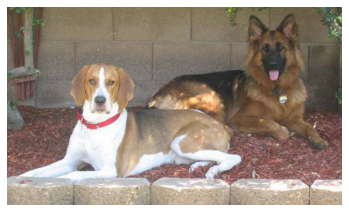

In [51]:
import matplotlib.pyplot as plt
from PIL import Image
print(image[1])
img = Image.open(image[1])
plt.axis('off')
plt.imshow(img)

# preprocessing

In [52]:
# cat:0 dog:1
import pandas as pd
cat_list = glob.glob('train/cat.*')
dog_list = glob.glob('train/dog.*')

cat_df = pd.DataFrame({'path':cat_list,'target':[0] * len(cat_list)})
dog_df = pd.DataFrame({'path':dog_list,'target':[1] * len(dog_list)})
data_df = pd.concat([cat_df, dog_df], axis=0)

In [53]:
import numpy as np
x, y = np.array(data_df['path']), np.array(data_df['target'])

In [54]:
'''
from VGG16 API

The default input size for this model is 224x224.
Note: each Keras Application expects a specific kind of input preprocessing. 
    vgg16.preprocess_input will convert the input images from RGB to BGR, 
    then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
'''

from tensorflow.keras.applications.vgg16 import preprocess_input
batch_size = 10

def get_batch(x, y, batch_size):
  idx = np.random.randint(0, len(x), size=batch_size)  # random 10 index

  x_batch, x_original, y_batch = [], [], y[idx]

  for i in x[idx]:
    batch_array = np.array(Image.open(i).resize((224,224)).convert('RGB'))
    x_batch.append(preprocess_input(batch_array))
    x_original.append(batch_array)

  return (np.array(x_batch), np.array(y_batch), np.array(x_original))

x_batch, y_batch, x_original = get_batch(x, y, batch_size)

print(x_batch.shape)
print(y_batch.shape)
print(x_original.shape)

(10, 224, 224, 3)
(10,)
(10, 224, 224, 3)


# transfer model

In [55]:
# VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_model = VGG16(include_top=False, input_shape=(224,224,3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

vgg16_layers = vgg16_model.layers

# we don't need to train the weights in vgg16
for layer in vgg16_layers:
  layer.trainable = False

# connect mlp without normalization
mlp_layers = [
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(2, activation='softmax')
]
transfer_vgg16_model = Sequential(vgg16_layers + mlp_layers)


# connect mlp with batchnormalization
mlp_layers_nor = [
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(2, activation='softmax')
]
nor_transfer_vgg16_model = Sequential(vgg16_layers + mlp_layers_nor)

# GAP with batchnormalization
gap_layers_nor = [
        BatchNormalization(),
        GlobalAveragePooling2D(),       
        Dense(2, activation='softmax')
]
gap_transfer_vgg16_model = Sequential(vgg16_layers + gap_layers_nor)

In [57]:
transfer_vgg16_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [58]:
nor_transfer_vgg16_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [59]:
gap_transfer_vgg16_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [62]:
# loss
model_list = [transfer_vgg16_model, nor_transfer_vgg16_model, gap_transfer_vgg16_model]
model_use = model_list[2]
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model_use.compile(optimizer='adam',
               loss=SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

# training

In [63]:
for i in range(20):
  print('-'*5, i, '-'*5)
  x_batch, y_batch, x_original = get_batch(x, y, batch_size)
  train_result = model_use.train_on_batch(x_batch, y_batch)
  # print('[train] loss:', train_result[0], ', accuracy:', train_result[1])
  x_batch, y_batch, x_original = get_batch(x, y, batch_size)
  test_result = model_use.test_on_batch(x_batch, y_batch)
  # print('[validate] loss:', test_result[0], ', accuracy:', test_result[1])
  # print('\n')

----- 0 -----
----- 1 -----
----- 2 -----
----- 3 -----
----- 4 -----
----- 5 -----
----- 6 -----
----- 7 -----
----- 8 -----
----- 9 -----
----- 10 -----
----- 11 -----
----- 12 -----
----- 13 -----
----- 14 -----
----- 15 -----
----- 16 -----
----- 17 -----
----- 18 -----
----- 19 -----


# evaluating

In [64]:
# model_use.predict(x_batch)

array([[0.10257823, 0.8974218 ],
       [0.42130345, 0.57869655],
       [0.3536971 , 0.6463029 ],
       [0.09437748, 0.90562254],
       [0.703118  , 0.29688194],
       [0.97917753, 0.02082249],
       [0.251887  , 0.74811304],
       [0.55011415, 0.44988582],
       [0.49813822, 0.50186175],
       [0.124174  , 0.875826  ]], dtype=float32)

In [65]:
x_batch, y_batch, x_original = get_batch(x, y, 2000)
model_use.evaluate(x_batch, y_batch)

63/63 [==============================] - 14s 226ms/step - loss: 0.3752 - accuracy: 0.8355


[0.3751838803291321, 0.8355000019073486]

In [66]:
predict_x = model_use.predict(x_batch) 
pre = np.argmax(predict_x, axis=1)

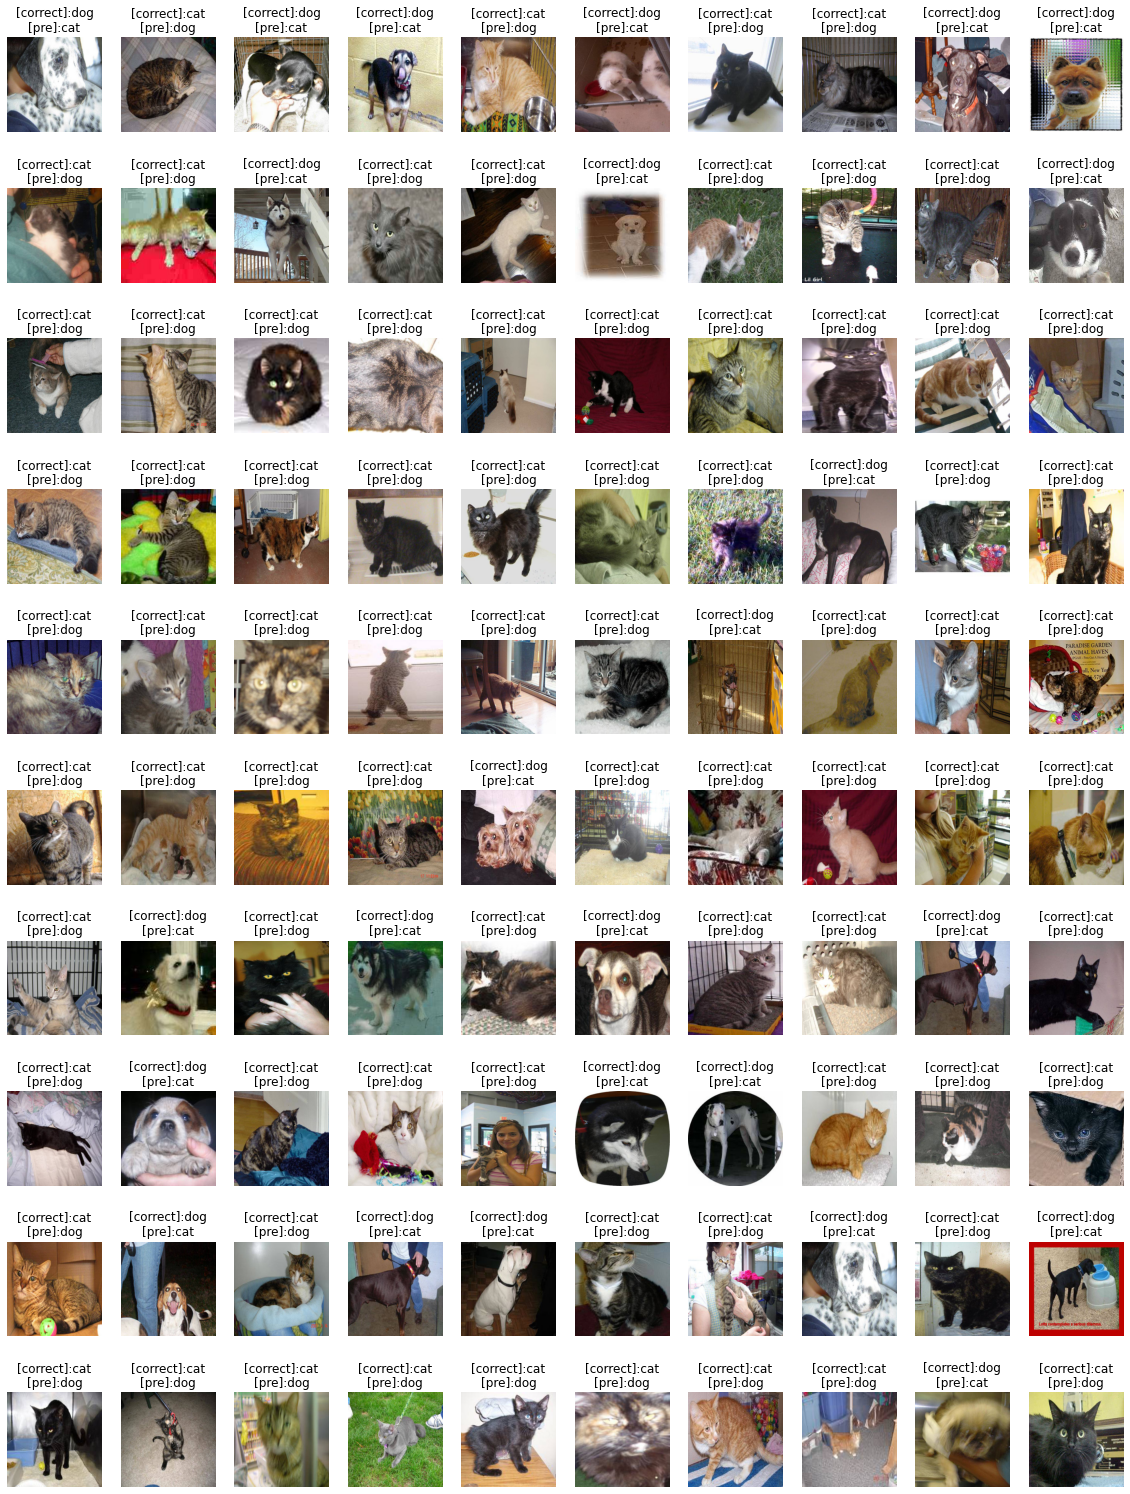

In [67]:
transform = ['cat', 'dog']
idx = np.nonzero(pre != y_batch)[0][100:200]

wrong_img, wrong_pre, wrong_label = x_original[idx], pre[idx], y_batch[idx]
plt.figure(figsize=(20,30))
w = 10
h = len(idx) / w + 1
for i in range(len(idx)):
  plt.subplot(h, w, i+1)
  plt.imshow(wrong_img[i])
  t = '[correct]:{0}\n[pre]:{1}'.format(transform[wrong_label[i]], transform[wrong_pre[i]])
  plt.title(t)
  plt.axis('off')